# 导入相关库

In [1]:
import jieba
import pandas as pd
import numpy as np
import re
from gensim import corpora
from sklearn.cluster import DBSCAN
from gensim.corpora import Dictionary
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from gensim.models import TfidfModel
import warnings
warnings.filterwarnings("ignore")

# 数据读取

In [2]:
comment_file_path = '评论数据/青岛水族馆.csv'
data_raw = pd.read_csv(comment_file_path).dropna(axis=0,how='any')
data_comment = list(data_raw['评论'])

# 数据预处理

## 分词

In [3]:
def string_seg(X):
    comments=[]
    for comment in X:
        r = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n。！，]+'
        comment = re.sub(r, '', str(comment))
        comment = jieba.cut(comment)
        comments.append(list(comment))
    return comments

In [4]:
X_seg = string_seg(data_comment)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ASUS\AppData\Local\Temp\jieba.cache
Loading model cost 0.636 seconds.
Prefix dict has been built successfully.


## 转化为矩阵

In [5]:
#利用词频词袋模型，将文字转化为矩阵
def feature_extract(X):
    dictionary = corpora.Dictionary(X)    
    # 将数据转换为稀疏矩阵
    corpus = [dictionary.doc2bow(text) for text in X]    
    data = []
    for i in corpus:
        data.append(dict(i))
    vec = DictVectorizer(sparse=True, dtype=np.uint8)
    data_new = vec.fit_transform(data)
    return data_new

In [6]:
X_new = feature_extract(X_seg)

In [7]:
pd.DataFrame(X_new.toarray())

,0,1,2,3,4,5,6,7,8,9,...,3703,3704,3705,3706,3707,3708,3709,3710,3711,3712
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 模型建立

## DBSCAN聚类

### 参数筛选

In [8]:
def clustering(X, eps=0.5, min_samples=2):
    db = DBSCAN(eps=eps, min_samples=2, n_jobs=-1)
    db.fit(X)
    labels = db.labels_
    return labels

In [9]:
#dbscan聚类参数筛选
def cluster_param_select(X, eps_begin=0.1, eps_end=2,strides=0.05):

    # 聚类簇列表、游离个体数列表
    num_clu_list = []
    num_indi_list = []
    # 产生迭代参数
    epsilon_list = np.arange(eps_begin, eps_end, strides)
    for eps in epsilon_list:
        labels = clustering(X, eps)
        # 聚类簇
        clusters = np.unique(labels)
        # 聚类簇数量
        num_clusters = len(clusters)
        # 游离个体数量
        individuals = list(filter(lambda x:x==-1, labels))
        # create list
        num_clu_list.append(num_clusters)
        num_indi_list.append(len(individuals))
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(left=0.125, bottom=None, right=0.9, top=None,
            wspace=0.3, hspace=None)
    plt.subplot(1,2,1) 
    plt.plot(epsilon_list, num_clu_list)                
    plt.xlabel(u'epsilon',fontsize=20)
    plt.ylabel(u'聚类数',fontsize=20)
    plt.subplot(1,2,2)
    plt.plot(epsilon_list, num_indi_list)      
    plt.xlabel(u'epsilon',fontsize=20)
    plt.ylabel(u'游离个体数',fontsize=20)  
    plt.show()


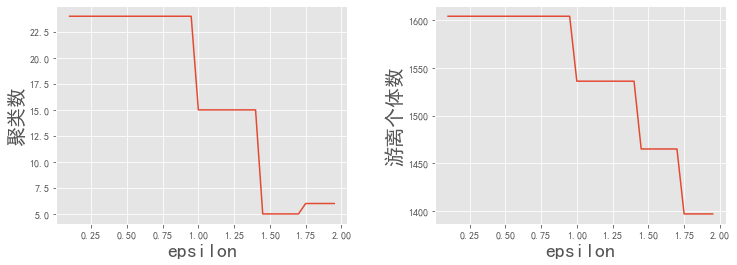

In [10]:
cluster_param_select(X_new)

### DBSCAN聚类

In [11]:
#查看聚类效果
def test_param(data_raw, labels, rank=1):
    X = data_raw
    X['所属簇'] = labels
    label_num = dict()
    labels_set = set(np.unique(labels)) 

    for label in labels_set:
        X_tmp = X.loc[X['所属簇']==label]['评论']
        label_num[label] = label_num.get(label, 0) + X_tmp.shape[0] 
    
    # 输出聚类簇-样品数
    print('聚类簇-样品数： ', label_num) 
    
    # 根据值排序
    label_num_sort = sorted(label_num.items(), key=lambda x: x[1], reverse=True)
    label_num_max = label_num_sort[rank][0] 
    # 输出内容
    X_tmp = X.loc[X['所属簇']==label_num_max]['评论'].values
    print('样品数%d多的聚类下，内容: \n'%rank, X_tmp)

In [12]:
#由图像选取两个eps值
eps_1=1
eps_2=0.9
labels_1 = clustering(X_new, eps_1)
labels_2 = clustering(X_new, eps_2)
test_param(data_raw, labels_1)
test_param(data_raw, labels_2)

聚类簇-样品数：  {0: 2, 1: 5, 2: 5, 3: 2, 4: 3, 5: 2, 6: 3, 7: 3, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, -1: 2084}
样品数1多的聚类下，内容: 
 ['景色不错，' '景色不错，' '景色不错，' '景色不错，' '景色不错，']
聚类簇-样品数：  {0: 2, 1: 5, 2: 5, 3: 2, 4: 3, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 3, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, -1: 2092}
样品数1多的聚类下，内容: 
 ['景色不错，' '景色不错，' '景色不错，' '景色不错，' '景色不错，']


### 评论有效性处理

In [13]:
def return_valid_result(data, labels):
    #label_num = dict()
    labels_set = set(np.unique(labels))
    data['所属簇'] = labels
    columns = data.columns
    data_valid = pd.DataFrame(columns=columns)
    for label in labels_set:
        # 游离数据不参与筛选
        if label == -1:
            df_valid_indiv = data.loc[data['所属簇'] == -1]
            data_valid = pd.concat([data_valid, df_valid_indiv])
            continue
        # 保留第一条
        df_valid_selection = data.loc[data['所属簇'] == label][0:1]
        if df_valid_selection.shape[0] > 1:
            df_valid_selection = df_valid_selection.sample(n=1)
        data_valid = pd.concat([data_valid, df_valid_selection])

    return data_valid

In [14]:
data = data_raw
data_valid = return_valid_result(data, labels_1)
data_valid.drop(['所属簇','Unnamed: 0'], axis=1, inplace=True)
data_valid=data_valid.reset_index(drop=True)
data_valid

,评论,得分,时间,点赞
0,为了迎接奥运会帆船比赛和打造“帆船之都”，青岛市人民政府把北海船厂整体搬迁到西海岸新区的海西...,5.0,2021/07/07,0
1,景色不错，,5.0,2021/06/22,0
2,有趣好玩，景色不错，体验很好，值得推荐，,5.0,2020/09/06,0
3,青岛国际奥帆中心，坐落于青岛市东部新区浮山湾畔，北海船厂原址，是2008年第29届北京奥运会...,4.4,2019/05/08,4
4,景色不错，体验很好，值得推荐，,4.4,2020/10/12,0
...,...,...,...,...
2118,差评 差评 差评 差评 差评 差评,4.4,2017/06/17,2
2119,5D电影千万不要去 不是电影 是立体图 骗钱的,4.4,2013/07/27,0
2120,人很多 景色太一般 周边配套设施也没什么 没有管理和服务,4.4,2017/08/20,0
2121,懵人的，就做了个大船，其他都是糊弄事，上当！,4.4,2017/04/10,0


In [15]:
data_valid.to_csv('clean_data/'+comment_file_path.split('.')[0].split('/')[1]+'new_.csv',encoding='utf_8_sig')